In [1]:
import tensorflow as tf
import numpy as np
from utilities.dataset_factory import DatasetFactory 
from utilities import visualization
import keras
from keras import Model
from keras import optimizers
from keras import metrics
from model.SiameseModel import SiameseModel
from distance.DistanceLayer import DistanceLayer
from utilities.output_signatures import OutputSignature

# Hyperparameters

In [2]:
image_size = (100, 100)
epochs = 10
batch_size = 16
margin = 0.5 # margin for triplet loss
training_triplets = 300
validation_triplets = 40
training_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Training"
validation_path = r".\data\Fruits360\archive\fruits-360-original-size\fruits-360-original-size\Validation"

In [3]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_triplets,
                                                output_signature=OutputSignature.triplet_loss)
print(training_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


# Creating validation_dataset from generator

In [4]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path, 
                                                  image_size=image_size,
                                                  batch_size=batch_size,
                                                  output_signature=OutputSignature.triplet_loss,
                                                  max_iterations=validation_triplets)
print(validation_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None))>


 # Visual verification of images from datasets

(100, 100, 3)


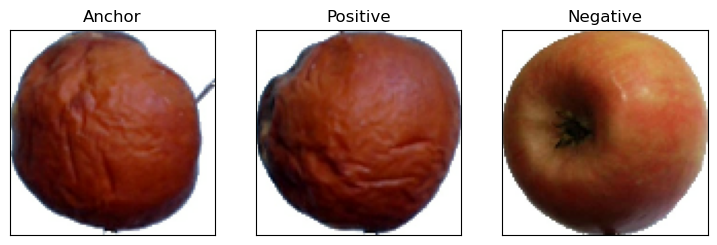

In [5]:
triplet_training = next(iter(training_dataset))

anchor_img = np.asarray(triplet_training[0][0]).astype('float32')
positive_img = np.asarray(triplet_training[1][0]).astype('float32')
negative_img = np.asarray(triplet_training[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)
print(anchor_img.shape)

(100, 100, 3)


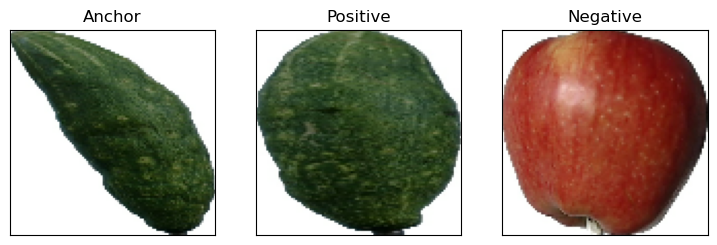

In [6]:
triplet_validation = next(iter(validation_dataset))

anchor_img = np.asarray(triplet_validation[0][0]).astype('float32')
positive_img = np.asarray(triplet_validation[1][0]).astype('float32')
negative_img = np.asarray(triplet_validation[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)
print(anchor_img.shape)

# Creating siamese model

In [7]:
input_layer = keras.layers.Input((100,100,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_model = keras.Model(input_layer, x)

# Adding merge layer and creating output layer

In [8]:
anchor_input = keras.layers.Input(name="anchor", shape=image_size + (3,))
positive_input = keras.layers.Input(name="positive", shape=image_size + (3,))
negative_input = keras.layers.Input(name="negative", shape=image_size + (3,))

distances = DistanceLayer()(
    embedding_model(anchor_input),
    embedding_model(positive_input),
    embedding_model(negative_input),
)

siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Compilation of our model and summary

In [9]:
siamese_network = SiameseModel(siamese_model, margin=margin)
siamese_network.compile(optimizer=optimizers.Adam(0.0001))
siamese_network.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ ?                      │       230,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,902 (901.96 KB)

 Trainable params: 199,920 (780.94 KB)

 Non-trainable params: 30,982 (121.02 KB)

# Training 

In [10]:
siamese_network.fit(training_dataset, epochs=epochs, batch_size=batch_size, validation_data=validation_dataset)

Epoch 1/10
     19/Unknown 8s 213ms/step - loss: 0.1881

C:\Users\matim\Apps\Anaconda3\envs\ml\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - loss: 0.1847 - val_loss: 0.0651
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.0532 - val_loss: 0.0211
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 0.0414 - val_loss: 0.0361
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0471 - val_loss: 0.0547
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0376 - val_loss: 0.0337
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - loss: 0.0330 - val_loss: 0.0403
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 0.0565 - val_loss: 0.0221
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.0110 - val_loss: 0.0163
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 0.0237 - val_loss: 0.0449
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 0.0237 - val_loss: 0.0000e+00


# Visualizing the next triplet

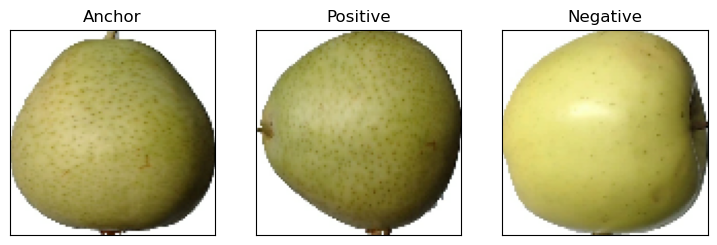

In [11]:
sample = next(iter(training_dataset))
anchor_img = np.asarray(sample[0][0]).astype('float32')
positive_img = np.asarray(sample[1][0]).astype('float32')
negative_img = np.asarray(sample[2][0]).astype('float32')

visualization.visualize(anchor_img, positive_img, negative_img)

# Evaluating the cosine similarity on trained model

In [12]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_model(anchor),
    embedding_model(positive),
    embedding_model(negative),
)
cosine_similarity = metrics.CosineSimilarity()

# Positive similarity should be larger than negative similarity
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9543656
Negative similarity 0.8220757
